#Azure Agent for Grounding with Bing Search

This tutorial demonstrates how to create and run a custom AI agent using Azure AI Projects, integrating Bing Search for real-time information retrieval. The agent is designed to ground its responses with up-to-date data from Bing, ensuring accurate and relevant answers to user queries.

Key Features:

* Utilizes Azure AI Projects to create an intelligent agent
* Implements Bing Search grounding to fetch real-time information
* Provides an interactive command-line interface for user interaction
* Showcases integration of external tools with an AI agent

#Prerequisites

1. Create Grounding with Bing resouce in azure
2. In your Azure AI Project, create a new Grounding with Bing search Connection to link it with Bing resource.

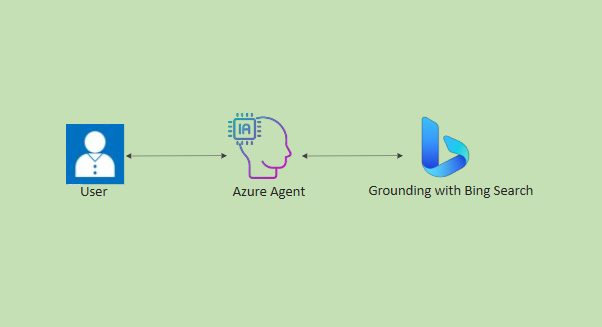

In [1]:
# Installs the Azure AI Projects SDK and Azure Identity library for authentication
#!pip install azure-ai-projects==1.0.0b8 azure-identity==1.21.0 load_dotenv

In [2]:
#Configure environment variables for Azure AI Project and Bing Search integration.

import os
from dotenv import load_dotenv
load_dotenv('agents.env')
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
TENANT_ID = os.getenv("TENANT_ID")
PROJECT_ENDPOINT = os.getenv("PROJECT_ENDPOINT")
BING_CONNECTION_NAME = os.getenv("BING_CONNECTION_NAME")
print(BING_CONNECTION_NAME)

In [ ]:
import os
from azure.ai.projects import AIProjectClient
from azure.identity import ClientSecretCredential
from azure.ai.agents.models import BingGroundingTool

# Configure Azure credentials
credential = ClientSecretCredential(
    tenant_id=os.getenv("TENANT_ID"),
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET")
)

# Initialize Azure AI Project Client
project_client = AIProjectClient(
    credential=credential, endpoint=os.getenv("PROJECT_ENDPOINT")
)

# Get Bing Search resource connection ID
bing_connection = project_client.connections.get(
    connection_name=os.getenv("BING_CONNECTION_NAME")
)
conn_id = bing_connection.id
print(f"Connection ID: {conn_id}")

# Initialize Bing grounding tool
bing = BingGroundingTool(connection_id=conn_id)

# Create the AI agent
agent = project_client.agents.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="My-Agent-for-Bing-Coding",
    instructions="You are a helpful assistant",
    tools=bing.definitions,
    headers={"x-ms-enable-preview": "true"}
)
print(f"Created agent, ID: {agent.id}")

# Create a conversation thread
thread = project_client.agents.threads.create()
print(f"Created thread, ID: {thread.id}")

# Interactive conversation loop
while True:
    user_input = input("User: ")
    if user_input.lower() == "end":
        project_client.agents.delete_agent(agent.id)
        print("Ending the conversation.")
        break

    # Send user message to the agent
    message = project_client.agents.messages.create(
        thread_id=thread.id,
        role="user",
        content=user_input,
    )

    # Process the agent's run
    run = project_client.agents.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)
    print(f"Run finished with status: {run.status}")

    if run.status == "failed":
        print(f"Run failed: {run.last_error}")
        break

    # Retrieve and display agent's response
    latest_message = next(msg for msg in project_client.agents.messages.list(thread_id=thread.id) if msg.role == "assistant")
    if agent_response := next((content.text.value for content in latest_message.content if content.type == "text"), None):
        print(f"Agent: {agent_response}")

print("Conversation ended")

Connection ID: /subscriptions/95717284-5de1-45e3-a461-5fe0db848584/resourceGroups/aoairg/providers/Microsoft.MachineLearningServices/workspaces/azure-ai-project-for-agent/connections/websearchcoding
Created agent, ID: asst_gZtQGMZqQIcXOVnqH7CfnCB3
Created thread, ID: thread_FxtzcR4eCRMUl5l4JdtcRft2
User: give latest news
Run finished with status: RunStatus.COMPLETED
Agent: Some of today's major news stories include closures of 112 Joann fabric stores across the U.S. and ongoing coverage of Russia’s drone barrage in Ukraine, following remarks by President Trump on Putin’s peace commitments【3:0†source】【3:4†source】. Let me know if you'd like specific details about any topic!
User: end
Ending the conversation.
Conversation ended
